# Importing Libraries and requirements

In [ ]:
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow
from skimage import feature
from sklearn.model_selection import train_test_split
import random
import cv2
import os
import matplotlib.pyplot as plt
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



In [ ]:
!pip install ipython-autotime #allows to measure the runtime

%load_ext autotime

time: 170 µs


# Importing Dataset from Kaggle

In [ ]:
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mehdinait","key":"8ccdc8b6ad6bd1f640c0e4371efe5fe2"}'}

time: 8.4 s


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d atulanandjha/lfwpeople -p dataset






100% 232M/232M [00:17<00:00, 12.7MB/s]

time: 21.2 s


In [ ]:
cd dataset

/content/dataset
time: 4.33 ms


In [ ]:

!unzip \*.zip
!rm lfwpeople.zip
!tar -xf lfw-funneled.tgz
!rm lfw-funneled.tgz


Archive:  lfwpeople.zip
  inflating: lfw-funneled.tgz        
  inflating: pairs.txt               
  inflating: pairsDevTest.txt        
  inflating: pairsDevTrain.txt       
time: 4.26 s


# Discovering the dataset

functions to be used during datset creation process

In [ ]:


def get_names(chemin):    #gets all the names of the persons in the dataset
  path=os.listdir(chemin)
  names=[]
  for pat in path:
    if pat[-4:]!=".txt":
      names.append(pat)
  return names


def get_sizes(names):   #Creates a list of the number of images of the input name list
  sizes=[]
  for name in names:
    i=0
    _path=os.listdir(chemin+"/"+name)
    #print(_path)
    for p in _path:
      if p[-4:]==".jpg":
        i=i+1
    sizes.append(i)
  return sizes

def get_names_below_N(names,sizes_,N): #Returns a list of persons with number of images below N
  N_names_below=[]
  N_sizes_below=[]
  for i in range(len(sizes_)):
    si=sizes_[i]
    if si<=N:
      N_names_below.append(names[i])
      N_sizes_below.append(si)
  return N_names_below,N_sizes_below


def get_names_above_N(names,sizes_,N): # Returns a reduced dataset where the number of images in each class is above N
  N_names_above=[]
  N_sizes_above=[]
  for i in range(len(sizes_)):
    si=sizes_[i]
    if si>=N:
      N_names_above.append(names[sizes_.index(si)])
      N_sizes_above.append(si)
  return N_names_above,N_sizes_above



def create_dataset_N(N_Names,taille):
  width = 25
  height = 25
  dim = (width, height)
  X=[]
  y=[]
  dat=[]
  list_names=N_Names
  for name in list_names:
    ch=os.listdir("lfw_funneled/"+name)
    for i in range(taille):
      chemin_image="lfw_funneled/"+name+"/"+ch[i]
      img=cv2.imread(chemin_image)
      gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
      resized=cv2.resize(gray,dim,interpolation = cv2.INTER_AREA)
      img=np.concatenate(resized)
      dat.append([img,list_names.index(name)])
      random.shuffle(dat) #shuffle data
      for features, label in dat:
        X.append(features)
        y.append(label)
  return X,y



def create_dataset_LBP_N(N_Names,taille):
  width = 25
  height = 25
  dim = (width, height)
  X=[]
  y=[]
  dat=[]
  list_names=N_Names
  for name in list_names:
    ch=os.listdir("lfw_funneled/"+name)
    for i in range(taille):
      chemin_image="lfw_funneled/"+name+"/"+ch[i]
      img=cv2.imread(chemin_image)
      gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
      gray=feature.local_binary_pattern(gray, 10, 1, method="ror")
      resized=cv2.resize(gray,dim,interpolation = cv2.INTER_AREA)
      img=np.concatenate(resized)
      dat.append([img,list_names.index(name)])
      random.shuffle(dat) #shuffle data
      for features, label in dat:
        X.append(features)
        y.append(label)
  return X,y

time: 66.1 ms


# Manipulating one image

In [ ]:
cd lfw_funneled

/content/dataset/lfw_funneled
time: 1.93 ms


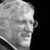

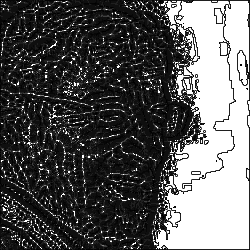

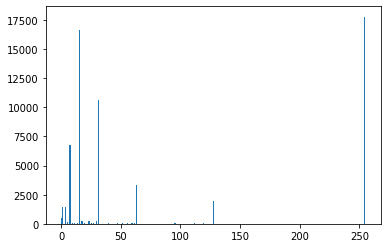

time: 537 ms


In [ ]:
#reading one image and displaying it alongside of the LBP feature and histograme of the same image
width = 50
height = 50
dim = (width, height)

img = cv2.imread('Thor_Pedersen/Thor_Pedersen_0001.jpg',cv2.IMREAD_UNCHANGED)
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img=cv2.resize(gray, dim, interpolation = cv2.INTER_AREA)
cv2_imshow(img)
feat = feature.local_binary_pattern(gray, 8, 1, method="ror")
print("\n")
cv2_imshow(feat)
testim=np.array(feat)
n, bins, patches=plt.hist(testim.flatten(),bins=range(256)) #calc the normalized hist the histograme
#n is the value of the bins (hist)
#bins are the values [0-255]
#patches : rectangles used to plot the hist

###### we are interested in the n vector

plt.show()


# Test of PCA and Standarization

Now that we know how to calculate the histogram , we can proceed to our dataset Preparation where we calculate our features using LBP, we Standarize the feature and then use PCA to reduce dimensiality

Before doing so ,we're gonna try if PCA impacts execution time, in order to do that , we will use 5 classes with 100 images each and compare

**Test without PCA / Standarization**

In [ ]:
##### creating datset

chemin="lfw_funneled/"
names=get_names(chemin) #liste tous les noms dans chemin
sizes_=get_sizes(names) #récupére le nombre d'image pour chaque nom
N_names_above=get_names_N(names,sizes_,100) #liste tous les noms dont le nombre d'images >=N
X,y=create_dataset_N(N_names_above,100) #crée une dataset d'images sans LBP de taille N pour chaque label [create_dataset_N(N_Names,taille)]


##### train test split
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.33, random_state=42)

##### training the model

clf = SVC(kernel="rbf",gamma="scale")
clf.fit(X_train, y_train)



##### prediction

y_pred = clf.predict(X_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))

Accuracy: 1.0
time: 9min 48s


In [ ]:
chemin="lfw_funneled/"
names=get_names(chemin) #liste tous les noms dans chemin
sizes_=get_sizes(names)
moy=0
for size in sizes_:
  moy=moy+size
moy=moy/len(sizes_)
print(moy)

2.301791615933206
time: 87.7 ms


**With PCA / Standarization**

In [ ]:

X_train1 = StandardScaler().fit_transform(X_train)
X_test1=StandardScaler().fit_transform(X_test)


# Make an instance of the Model
pca = PCA(.95)
pca.fit(X_train1)

X_train1 = pca.transform(X_train1)
X_test1 = pca.transform(X_test1)


clf = SVC(kernel="rbf",gamma="scale")
clf.fit(X_train1, y_train)



##### prediction

y_pred = clf.predict(X_test1)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))

Accuracy: 1.0
time: 2min 45s


**Conclusion** : use of PCA is a time saver

# Testing with the augmented dataset 
**(balanced with 100 images for each class 106 classes)**

**Creating an augmented dataset**


In [ ]:
cd ..

/content/dataset
time: 4.15 ms


In [ ]:
def augment(aug_names,aug_sizes,N):
  n=1
  for name in aug_names:
    taille=0
    path=chemin+"/"+name
    p=os.listdir(path)
    ind_name=aug_names.index(name)
    taille=aug_sizes[ind_name]
    taille_init=taille
    while(taille<=N):
      for im in p:
        im_path=path+"/"+im
        img = load_img(im_path)
        data = img_to_array(img)# convert to numpy array
        samples = expand_dims(data, 0)# expand dimension to one sample
        datagen = ImageDataGenerator(zoom_range=[0.7,0.8],rotation_range=90)# create image data augmentation generator
        it = datagen.flow(samples, batch_size=1)# prepare iterator
        batch = it.next()
        image = batch[0].astype('uint8')
        
        save_path=path+"/"+im[:-4]+str(taille)+"_aug.jpg"
        image_gray=cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_path, image_gray) 
        #im.save(save_path)
        taille=taille+1
        if taille>N:
          break
    print("file :"+name+" augmented initial size: "+str(taille_init)+" Current size: "+str(taille)+" remaining: "+str(len(aug_names)-n))

    n=n+1


time: 12.7 ms


In [ ]:
chemin="lfw_funneled"
names=get_names(chemin)
sizes=get_sizes(names)
aug_names,aug_sizes=get_names_above_N(names,sizes,14)
#Returns a list of 106 elements
augment(aug_names,aug_sizes,50)

file :Britney_Spears augmented initial size: 14 Current size: 51 remaining: 105
file :Hamid_Karzai augmented initial size: 22 Current size: 51 remaining: 104
file :Hans_Blix augmented initial size: 39 Current size: 51 remaining: 103
file :Pierce_Brosnan augmented initial size: 15 Current size: 51 remaining: 102
file :Britney_Spears augmented initial size: 14 Current size: 51 remaining: 101
file :Colin_Powell augmented initial size: 236 Current size: 236 remaining: 100
file :Spencer_Abraham augmented initial size: 17 Current size: 51 remaining: 99
file :Jeremy_Greenstock augmented initial size: 24 Current size: 51 remaining: 98
file :Britney_Spears augmented initial size: 14 Current size: 51 remaining: 97
file :Jeremy_Greenstock augmented initial size: 24 Current size: 51 remaining: 96
file :Fidel_Castro augmented initial size: 18 Current size: 51 remaining: 95
file :Pierce_Brosnan augmented initial size: 15 Current size: 51 remaining: 94
file :Joschka_Fischer augmented initial size: 19

In [ ]:
chemin="lfw_funneled"
names=get_names(chemin)
sizes=get_sizes(names)
names_above,sizes_above=get_names_above_N(names,sizes,100)
moy=0
for size in sizes_above:
  moy=moy+size
moy=moy/len(sizes_above)
print(moy)

205.75
time: 82.3 ms


**Without LBP**

at this step, we had memory issues, as the creation of the augmented dataset was using all the available RAM, as a result , the notebook crashes. we thought of reducing the size of the images but that didn't work either, now we're gonna try to use histograms as inputs for our models.

update : le problème persiste, la seule solution est de réduire la dataset...

In [ ]:
#SVM without LBP
names=get_names(chemin)
sizes=get_sizes(names)
N_names_above,N_sizes_above=get_names_above_N(names,sizes,100)
X,y=create_dataset_N(N_names_above,100)

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.33, random_state=42)

X_train = StandardScaler().fit_transform(X_train)
X_test=StandardScaler().fit_transform(X_test)


# Make an instance of the Model
pca = PCA(.95)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)


clf = SVC(kernel="rbf",gamma="scale")
clf.fit(X_train, y_train)



##### prediction

y_pred = clf.predict(X_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))

Accuracy: 1.0
time: 25min 6s


overfitting ?

**With LBP**

In [ ]:
#SVM with LBP


names=get_names(chemin)
sizes=get_sizes(names)
N_names_above,N_sizes_above=get_names_above_N(names,sizes,100)
X,y=create_dataset_LBP_N(N_names_above,100)


X_train1,X_test1,y_train,y_test=train_test_split(X, y, test_size=0.33, random_state=42)

X_train1 = StandardScaler().fit_transform(X_train1)
X_test1=StandardScaler().fit_transform(X_test1)


# Make an instance of the Model
pca = PCA(.95)
pca.fit(X_train1)

X_train1 = pca.transform(X_train1)
X_test1 = pca.transform(X_test1)


clf = SVC(kernel="rbf",gamma="scale")
clf.fit(X_train1, y_train)



##### prediction

y_pred1 = clf.predict(X_test1)
print("Accuracy: "+str(accuracy_score(y_test, y_pred1)))

Accuracy: 1.0
time: 50min 34s


over-fitting confirmed, the data augmentation is worthless, maybe we should consider using GAN

**ANN**

In [ ]:
################## ANN WITH LPB  ##################""""
names=get_names(chemin)
sizes=get_sizes(names)
N_names_above,N_sizes_above=get_names_above_N(names,sizes,100)
X,y=create_dataset_LBP_N(N_names_above,100)


X_train1,X_test1,y_train,y_test=train_test_split(X, y, test_size=0.33, random_state=42)

X_train1 = StandardScaler().fit_transform(X_train1)
X_test1=StandardScaler().fit_transform(X_test1)


# Make an instance of the Model
pca = PCA(.95)
pca.fit(X_train1)

X_train1 = pca.transform(X_train1)
X_test1 = pca.transform(X_test1)

i=25
j=27
k=28
clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(i, j, k), random_state=1)
print ("processing: ", i, ' ', j, ' ', k)
clf.fit(X_train1, y_train)
predicted = clf.predict(X_test1)
#print(predicted)
#print(y_test)
accuracy = accuracy_score(y_test, predicted)
print("acc ", accuracy)


In [ ]:
#SVM without LBP
names=get_names(chemin)
sizes=get_sizes(names)
N_names_above,N_sizes_above=get_names_above_N(names,sizes,100)
X,y=create_dataset_N(N_names_above,100)

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.33, random_state=42)

X_train = StandardScaler().fit_transform(X_train)
X_test=StandardScaler().fit_transform(X_test)


# Make an instance of the Model
pca = PCA(.95)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
best_accuracary = 0
best_architecture = (0, 0, 0)
for i in range (25, 31):
  for j in range (25, 31):
    for k in range (25, 31):
      clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(i, j, k), random_state=1)
      print ("processing: ", i, ' ', j, ' ', k)
      clf.fit(X_train, y_train)
      predicted = clf.predict(X_test)
      #print(predicted)
      #print(y_test)
      accuracy = accuracy_score(y_test, predicted)
      print("acc ", accuracy)
      if (accuracy > best_accuracary):
        best_accuracary = accuracy
        best_architecture = (i, j, k)
        print("current best:  acc = ", best_accuracary, "   arch = ", best_architecture)

#original dataset (No augmentation)


**Without LBP**

In [ ]:
chemin="lfw_funneled"
names=get_names(chemin)
sizes=get_sizes(names)
aug_names,aug_sizes=get_names_above_N(names,sizes,50)
X,y=create_dataset_N(aug_names,50)
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.33, random_state=42)

X_train = StandardScaler().fit_transform(X_train)
X_test=StandardScaler().fit_transform(X_test)


# Make an instance of the Model
pca = PCA(.95)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
clf = SVC(kernel="rbf",gamma="scale")
clf.fit(X_train, y_train)



##### prediction

y_pred2 = clf.predict(X_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred2)))

Accuracy: 0.999932771979361
time: 1min 7s


**Résultat SVM sans lbp**



**Accuracy**: 0.9999942370752004

time: 3min 19s

In [ ]:
best_accuracary = 0
best_architecture = (0, 0, 0)

for i in range (25, 26):
  for j in range (25, 31):
    for k in range (25, 31):
      clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(i, j, k), random_state=1)
      print ("processing: ", i, ' ', j, ' ', k)
      clf.fit(X_train, y_train)
      predicted3 = clf.predict(X_test)
      #print(predicted)
      #print(y_test)
      accuracy = accuracy_score(y_test, predicted3)
      print("acc ", accuracy)
      if (accuracy > best_accuracary):
        best_accuracary = accuracy
        best_architecture = (i, j, k)
        print("current best:  acc = ", best_accuracary, "   arch = ", best_architecture)

processing:  25   25   25
acc  0.9999538966016033
current best:  acc =  0.9999538966016033    arch =  (25, 25, 25)
processing:  25   25   26
acc  0.999971185376002
current best:  acc =  0.999971185376002    arch =  (25, 25, 26)
processing:  25   25   27
acc  0.9999769483008016
current best:  acc =  0.9999769483008016    arch =  (25, 25, 27)
processing:  25   25   28
acc  0.999971185376002
processing:  25   25   29
acc  0.9999538966016033
processing:  25   25   30
acc  0.9999481336768037
processing:  25   26   25
acc  0.9999481336768037
processing:  25   26   26
acc  0.9999481336768037
processing:  25   26   27
acc  0.9999481336768037
processing:  25   26   28
acc  0.9999769483008016
processing:  25   26   29
acc  0.9999596595264029
processing:  25   26   30
acc  0.999971185376002
processing:  25   27   25
acc  0.999971185376002
processing:  25   27   26
acc  0.9999423707520041
processing:  25   27   27
acc  0.999971185376002
processing:  25   27   28
acc  0.9999942370752004
current bes

**Résultat ANN sans lbp**


**ACCURACY**: 0.9999942370752004

best architecture: (25, 27, 28)


**LBP**

In [ ]:
chemin="lfw_funneled"
names=get_names(chemin)
sizes=get_sizes(names)
N_names_above,N_sizes_above=get_names_above_N(names,sizes,25)

X,y=create_dataset_LBP_N(N_names_above,25)


X_train1,X_test1,y_train,y_test=train_test_split(X, y, test_size=0.33, random_state=42)

X_train1 = StandardScaler().fit_transform(X_train1)
X_test1=StandardScaler().fit_transform(X_test1)


# Make an instance of the Model
pca = PCA(.95)
pca.fit(X_train1)

X_train1 = pca.transform(X_train1)
X_test1 = pca.transform(X_test1)


time: 52.4 s


In [ ]:
clf = SVC(kernel="rbf",gamma="scale")
clf.fit(X_train1, y_train)



##### prediction

y_pred3 = clf.predict(X_test1)
print("Accuracy: "+str(accuracy_score(y_test, y_pred3)))

Accuracy: 0.999994508089584
time: 7min 47s


In [ ]:
t=0
for i in range(len(y_pred3)):
  if y_pred3[i]!=y_test[i]:
    t=t+1
print(t)


1
time: 66.5 ms


In [ ]:
print(pred)


Accuracy: 0.9999615566270883

time: 10min 33s

In [ ]:


i=25
j=27
k=28

clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(i, j, k), random_state=1)
print ("processing: ", i, ' ', j, ' ', k)
clf.fit(X_train1, y_train)
predicted1 = clf.predict(X_test1)
accuracy = accuracy_score(y_test, predicted1)
print("acc ", accuracy)


processing:  25   27   28
acc  0.9999505728062564
time: 2min 37s


acc  0.9999505728062564

time: 2min 37s